### Model
Multi layer CNN in Keras to classify


In [1]:
# Importing * the libraries
from __future__ import division
import numpy as np
import os,glob
from PIL import Image
from random import *
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

/home/devops2/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/devops2/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/devops2/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/devops2/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

Model is built on handwriting from 50 different writers
so the class will be 50

In [2]:
file = 'forms_for_parsing.txt'

In [3]:
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = tf.Session(config=config)

In [4]:
# create sentance writer mapping
# dictionary with form and writer mapping
d = {}
with open(file) as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer

In [5]:
# create array of file names and corresponding target writer names
tmp = []
target_list = []
path_to_files = os.path.join('data_subset', '*')

In [6]:
path_to_files

'data_subset/*'

In [7]:
for filename in sorted(glob.glob(path_to_files)):
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)

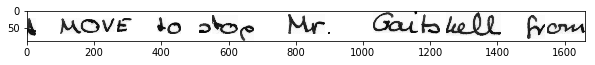

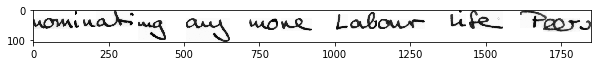

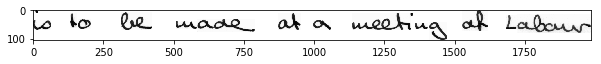

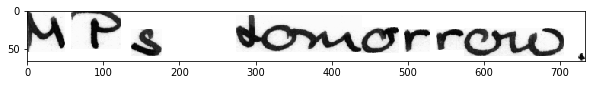

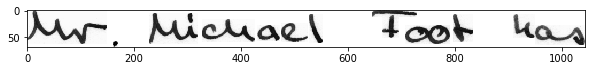

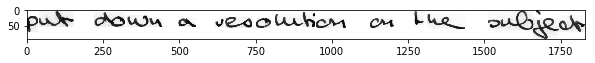

In [8]:
# visualizing data
for filename in img_files[:6]:
    img = mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray')

In [9]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

In [10]:
img_files[:5], img_targets[:5], encoded_Y[:5]

(array(['data_subset/a01-000u-s00-00.png',
        'data_subset/a01-000u-s00-01.png',
        'data_subset/a01-000u-s00-02.png',
        'data_subset/a01-000u-s00-03.png',
        'data_subset/a01-000u-s01-00.png'], dtype='<U35'),
 array(['000', '000', '000', '000', '000'], dtype='<U3'),
 array([0, 0, 0, 0, 0]))

In [11]:
encoded_Y

array([ 0,  0,  0, ..., 47, 47, 47])

In [12]:
img_targets

array(['000', '000', '000', ..., '635', '635', '635'], dtype='<U3')

In [13]:
train_files, rem_files, train_targets, rem_targets = train_test_split(img_files, encoded_Y, train_size=0.66, random_state=50, shuffle=True)

In [14]:
validation_files, test_files, validation_targets, test_targets = train_test_split(
rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

In [15]:
train_files.shape, validation_files.shape, test_files.shape

((3233,), (833,), (833,))

### Input to the model
* random patches cropped from each sequence. 
* resized each sentance so that new height is 113px and new width
* distorting the shape of image by changing the aspect ratio
* adjusted image, patches of 113*113 are randomly cropped

In [16]:
# Generator function for generating random crops from each sequence
# # Now create generates for randomly cropping 113*113 patches from these images

In [17]:
batch_size = 20
num_classes = 50

In [18]:
def generate_file_data(samples, target_files, batch_size=batch_size, factor=0.1):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]
            
            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]
                
                height_fac = 113 / cur_height
                
                new_width = int(cur_width * height_fac)
                size = new_width, 113
                
                imresize = im.resize((size), Image.ANTIALIAS)
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                
                #generate crops of size 113*113 from this resized image and keep random 10% of crops
                
                avail_x_points = list(range(0, now_width - 113))
                
                #pick random x%
                pick_num = int(len(avail_x_points) * factor)
                
                #now pick
                random_startx = sample(avail_x_points, pick_num)
                
                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)
                
                #trim image to only see section with road
                
                X_train = np.array(images)
                y_train = np.array(targets)
                
                #reshape X_train for feeding in later
                X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
                # convert to float and normalize
                X_train = X_train.astype('float32')
                X_train /= 255
                
                #one hot encode y
                y_train = to_categorical(y_train, num_classes)
                
                yield shuffle(X_train, y_train)
                    

In [19]:
# geneartiing data from training and validation

train_generator = generate_file_data(train_files, train_targets, batch_size=batch_size, factor=0.3)

In [20]:
validation_generator = generate_file_data(validation_files, validation_targets, batch_size=batch_size, factor=0.3)

#### Building a neural network in Keras

###### Type of popular neural network
* Sigmoid or Logistic
* Tanh — Hyperbolic tangent
* ReLu -Rectified linear units

In [ ]:
# function to resize image to 56*56

def resize_image(image):
    return tf.image.resize(image,[56, 56])

# Function to resize image to 64*64

row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1,1), input_shape=(row, col, ch)))

# Resize data withing the neural network
model.add(Lambda(resize_image)) # resize images to allow for easy computation

#Using CNN model - Building the model suggested in paper

#LAYER 1 
model.add(Convolution2D(filters=32, kernel_size=(5,5), strides=(2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='pool1'))

#LAYER 2
model.add(Convolution2D(filters= 64, kernel_size=(3,3), strides=(1,1), padding='same', name='conv2')) #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='pool2'))

#Layer 3
model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))

model.add(Flatten()) #=> Return copy of original array, If you modify any value of this array value of original array is not affected
model.add(Dropout(0.5)) #=> Dropout is easily implemented by randomly selecting nodes to be dropped-out with a given probability (e.g. 20%) each weight update cycle.

model.add(Dense(512, name='dense1'))
#add (BatchNormalization)
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, name='output'))
model.add(Activation('softmax')) #=> softmax since output is withing 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)      

 #### Train the model


In [ ]:
nb_epoch = 8
samples_per_epoch = 3268
nb_val_samples = 1

# save every model using keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath = 'checkpoint/check-{epoch:02d}-{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

# Model fit generator
history_object = model.fit_generator(train_generator, samples_per_epoch=samples_per_epoch, validation_data=
                                    validation_generator, nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)


/home/devops2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/home/devops2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=3268, epochs=8, validation_steps=1)`
  del sys.path[0]



Epoch 1/8
1146/3268 [=========>....................] - ETA: 29:52 - loss: 3.5494 - accuracy: 0.2155

### Test model performance

In [ ]:
import tensorflow as tf

In [ ]:
images = []
for filename in test_files[:50]:
    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]

    # print(cur_width, cur_height)
    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
    now_width = imresize.size[0]
    now_height = imresize.size[1]
    # Generate crops of size 113x113 from this resized image and keep random 10% of crops

    avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

    # Pick random x%
    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
    
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images.append(np.asarray(imcrop))
        
    X_test = np.array(images)
    
    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
    #convert to float and normalize
    X_test = X_test.astype('float32')
    X_test /= 255
    shuffle(X_test)

print(X_test.shape)

In [ ]:
predictions = model.predict(X_test, verbose=1)
predictions.shape
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

In [ ]:
writer_number = 18
total_images = 10
counter = 0

In [ ]:
for i in range(len(predicted_writer)):
    if predicted_writer[i] == writer_number:
        print('xx')